# Using Albumentations to augment bounding boxes for object detection tasks

### Import the required libraries

In [1]:
%matplotlib inline

In [45]:
import random
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import cv2
from matplotlib import pyplot as plt

import albumentations as A


### Define functions to visualize bounding boxes and class labels on an image

The visualization function is based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

In [3]:
def denormalize_bbox(bbox, rows: int, cols: int):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.

    Args:
        bbox: Normalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows: Image height.
        cols: Image width.

    Returns:
        Denormalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """
    # tail: Tuple[Any, ...]
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    x_min, x_max = x_min * cols, x_max * cols
    y_min, y_max = y_min * rows, y_max * rows

    return (x_min, y_min, x_max, y_max) + tail  # + tail  # type: ignore


def convert_bbox_to_albumentations(bbox):
    """Denormalize a list of bounding boxes.

    Args:
        bboxes: Normalized bounding boxes `[(x_min, y_min, x_max, y_max)]`.
        rows: Image height.
        cols: Image width.

    Returns:
        List: Denormalized bounding boxes `[(x_min, y_min, x_max, y_max)]`.

    """
    (x, y, w, h), tail = bbox[:4], bbox[4:]

    w_half, h_half = w / 2, h / 2
    x_min = x - w_half
    y_min = y - h_half
    x_max = x_min + w
    y_max = y_min + h
    bbox = (x_min, y_min, x_max, y_max) + tuple(tail)  # type: ignore
    return bbox


In [47]:
mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]


In [48]:
denorm = A.transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1.0 / s for s in std],
    always_apply=True,
    max_pixel_value=1.0,
)
# a = (denorm(image=a)["image"]*255).astype(np.uint8)


In [59]:
BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = denormalize_bbox(bbox, len(img), len(img[0]))
    # print(f"Visualizes{len(img[0])},{len(img[1])}")
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(
        class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
    )
    cv2.rectangle(
        img,
        (x_min, y_min - int(1.3 * text_height)),
        (x_min + text_width, y_min),
        BOX_COLOR,
        -1,
    )
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = np.transpose(image.clone().numpy(), (1, 2, 0))
    img = (denorm(image=img)["image"] * 255).astype(np.uint8)
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        # print(f"visualize{bbox}")
        img = visualize_bbox(img, convert_bbox_to_albumentations(bbox), class_name)
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.imshow(img)


### Get an image and annotations for it

For this example we will use an image from the [COCO dataset](https://cocodataset.org/) that have two associated bounding boxes. The image is available at http://cocodataset.org/#explore?id=386298

#### Load the image from the disk

In [5]:
image = cv2.imread("data/coco128/images/train2017/000000000308.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [6]:
len(image)


426

#### Define two bounding boxes with coordinates and class labels

Coordinates for those bounding boxes are declared using the `coco` format. Each bounding box is described using four values `[x_min, y_min, width, height]`. For the detailed description of different formats for bounding boxes coordinates, please refer to the documentation article about bounding boxes - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/.

In [7]:
bboxes = [
    [0.3149060010910034, 0.5313850045204163, 0.20893700420856476, 0.9282630085945129],
    [0.1445939987897873, 0.5555279850959778, 0.2891879975795746, 0.8889439702033997],
    [0.19878900051116943, 0.34808701276779175, 0.25464099645614624, 0.6241549849510193],
    [0.20068000257015228, 0.28793400526046753, 0.0539219006896019, 0.20610299706459045],
    [0.7327970266342163, 0.5198469758033752, 0.2746880054473877, 0.9295070171356201],
    [0.5886330008506775, 0.5958219766616821, 0.038203101605176926, 0.1403290033340454],
    [0.26745301485061646, 0.4828760027885437, 0.07759369909763336, 0.23312200605869293],
    [0.38722699880599976, 0.4196479916572571, 0.03882810100913048, 0.1375119984149933],
    # [0.09348440170288086, 0.77190101146698, 0.18696899712085724, 0.4337089955806732],
    [0.0934844, 0.771901, 0.186969, 0.433709],
    [0.052820298820734024, 0.5494130253791809, 0.10554700344800949, 0.2985450029373169],
    [0.5792890191078186, 0.37849798798561096, 0.07795310020446777, 0.41380301117897034],
    [0.6918519735336304, 0.573743999004364, 0.02045309916138649, 0.030727699398994446],
    [0.5000699758529663, 0.23572799563407898, 0.13689100742340088, 0.17502300441265106],
]
# 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0,40.0, 0.0, 40.0,0.0, 74.0,
category_ids = [0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 0.0, 40.0, 0.0, 74.0, 25.0]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {
    0: "human",
    23: "giraffe",
    25: "umbrella",
    40: "wine glass",
    74: "clock",
}


In [8]:
# import numpy as np

# lb = np.array(
#     [
#         [0.0, 0.0934844, 0.771901, 0.186969, 0.433709],
#         [
#             0.0,
#             0.052820298820734024,
#             0.5494130253791809,
#             0.10554700344800949,
#             0.2985450029373169,
#         ],
#     ],
#     dtype=np.float32,
# )
# (lb[:, 1] - lb[:, 3] / 2 < 0).all()


In [9]:
# for bbox in lb[:,1:]:
#     xyxy = convert_bbox_to_albumentations(bbox)
#     # print(denormalize_bbox(xyxy, len(image), len(image[0])))
#     print(xyxy)


In [10]:
# if (lb[:, 1] - lb[:, 3] / 2 < 0).all():
#                             lb = (
#                                 lb[:, 3][lb[:, 1] - lb[:, 3] / 2 < 0]
#                                 - lb[:, 1][lb[:, 1] - lb[:, 3] / 2 < 0]
#                                 - lb[:, 3][lb[:, 1] - lb[:, 3] / 2 < 0]
#                             )
#                             print(lb)


In [11]:
# np.isclose(lb[:, 1] - lb[:, 3] / 2, 0)


#### Visuaize the original image with bounding boxes

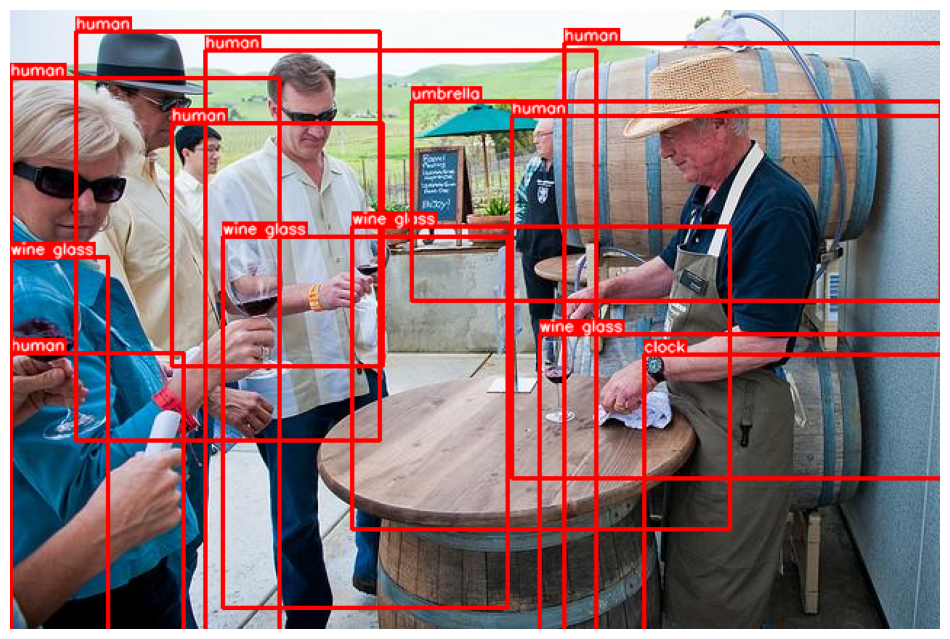

In [12]:
visualize(image, bboxes, category_ids, category_id_to_name)


In [74]:
image = cv2.imread("data/coco128/images/train2017/000000000025.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = [
    [0.770336, 0.489695, 0.335891, 0.697559],
    [0.185977, 0.901608, 0.206297, 0.129554],
]
# 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 40.0,40.0, 0.0, 40.0,0.0, 74.0,
category_ids = [23.0, 23.0]
visualize(image, bboxes, category_ids, category_id_to_name)


AttributeError: 'numpy.ndarray' object has no attribute 'clone'

In [14]:
# for bbox in bboxes:
#     xyxy = convert_bbox_to_albumentations(bbox)
#     print(denormalize_bbox(xyxy, len(image[0]), len(image)))


In [15]:
# image = cv2.imread("data/coco128/images/train2017/000000000025.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2.rectangle(image, (256, 90), (399, 536), color=BOX_COLOR, thickness=3)
# plt.figure(figsize=(12, 12))
# plt.axis("off")
# plt.imshow(image)


### Define an augmentation pipeline

To make an augmentation pipeline that works with bounding boxes, you need to pass an instance of `BboxParams` to `Compose`. In `BboxParams` you need to specify the format of coordinates for bounding boxes and optionally a few other parameters. For the detailed description of `BboxParams` please refer to the documentation article about bounding boxes - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/.

In [16]:
transform = A.Compose(
    [A.HorizontalFlip(p=0.5)],
    bbox_params=A.BboxParams(
        format="yolo",
        label_fields=["category_ids"],
        # min_area=100.0,
        # check_each_transform=False,
    ),
)


We fix the random seed for visualization purposes, so the augmentation will always produce the same result. In a real computer vision pipeline, you shouldn't fix the random seed before applying a transform to the image because, in that case, the pipeline will always output the same image. The purpose of image augmentation is to use different transformations each time.

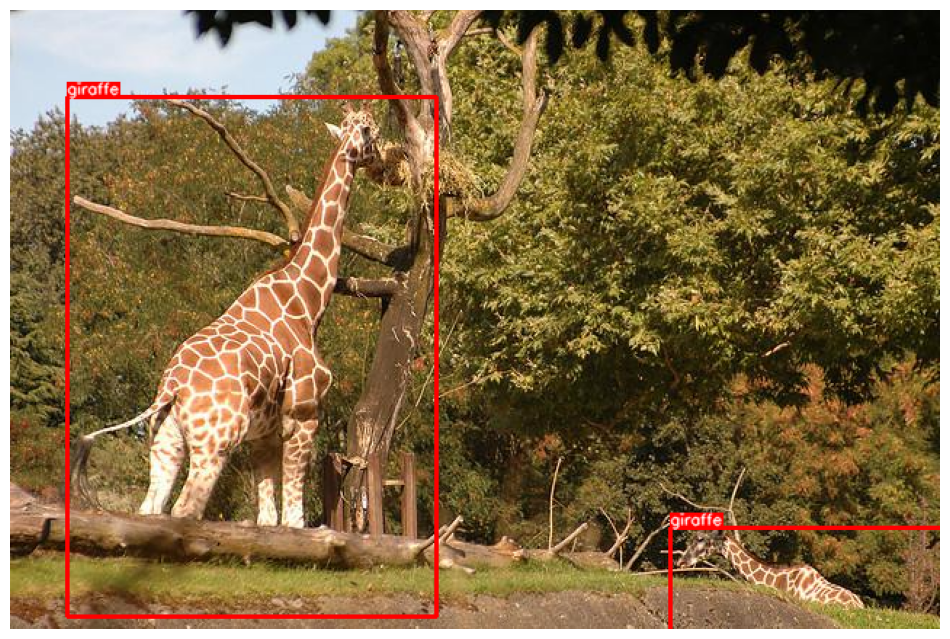

In [17]:
random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed["image"],
    transformed["bboxes"],
    transformed["category_ids"],
    category_id_to_name,
)


### Another example

In [64]:
transform = A.Compose(
    [
        A.ShiftScaleRotate(rotate_limit=20, p=0.7),
        A.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"]),
)


In [42]:
np.transpose(
    transformed["image"].numpy(), (1, 2, 0)
).shape  # .permute(2, 0, 1)  # convert HWC to CHW


(426, 640, 3)

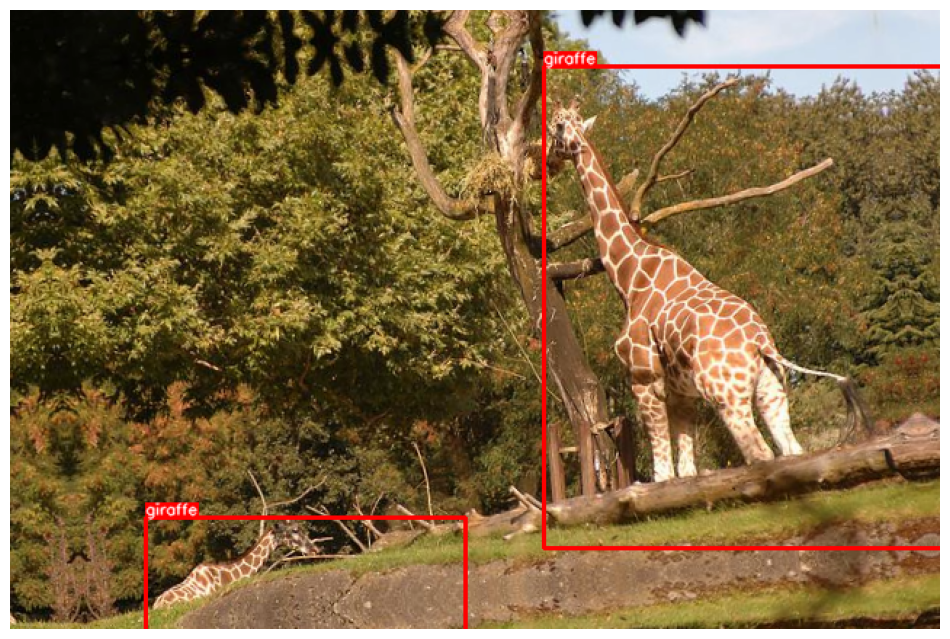

In [65]:
random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed["image"],
    transformed["bboxes"],
    transformed["category_ids"],
    category_id_to_name,
)


### Define a complex augmentation piepline

In [66]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
        A.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"]),
)


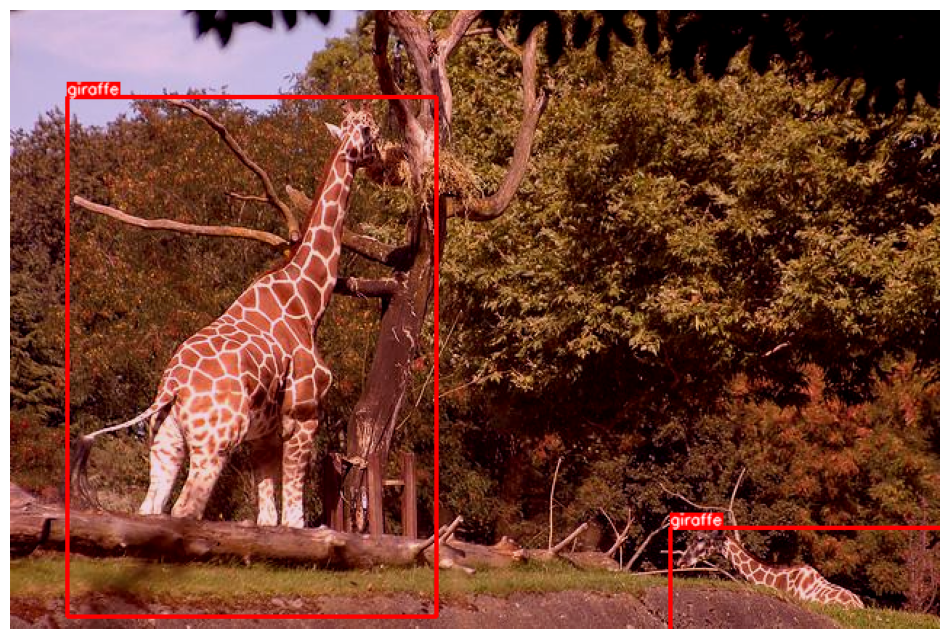

In [67]:
random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed["image"],
    transformed["bboxes"],
    transformed["category_ids"],
    category_id_to_name,
)


### `min_area` and `min_visibility` parameters

The size of bounding boxes could change if you apply spatial augmentations, for example, when you crop a part of an image or when you resize an image.

`min_area` and `min_visibility` parameters control what Albumentations should do to the augmented bounding boxes if their size has changed after augmentation. The size of bounding boxes could change if you apply spatial augmentations, for example, when you crop a part of an image or when you resize an image.

`min_area` is a value in pixels. If the area of a bounding box after augmentation becomes smaller than `min_area`, Albumentations will drop that box. So the returned list of augmented bounding boxes won't contain that bounding box.

`min_visibility` is a value between 0 and 1. If the ratio of the bounding box area after augmentation to `the area of the bounding box before augmentation` becomes smaller than `min_visibility`, Albumentations will drop that box. So if the augmentation process cuts the most of the bounding box, that box won't be present in the returned list of the augmented bounding boxes.


### Define an augmentation pipeline with the default values for `min_area` and `min_visibilty`

If you don't pass the `min_area` and `min_visibility` parameters, Albumentations will use 0 as a default value for them.

In [68]:
transform = A.Compose(
    [
        A.CenterCrop(height=280, width=280, p=1),
        A.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"]),
)


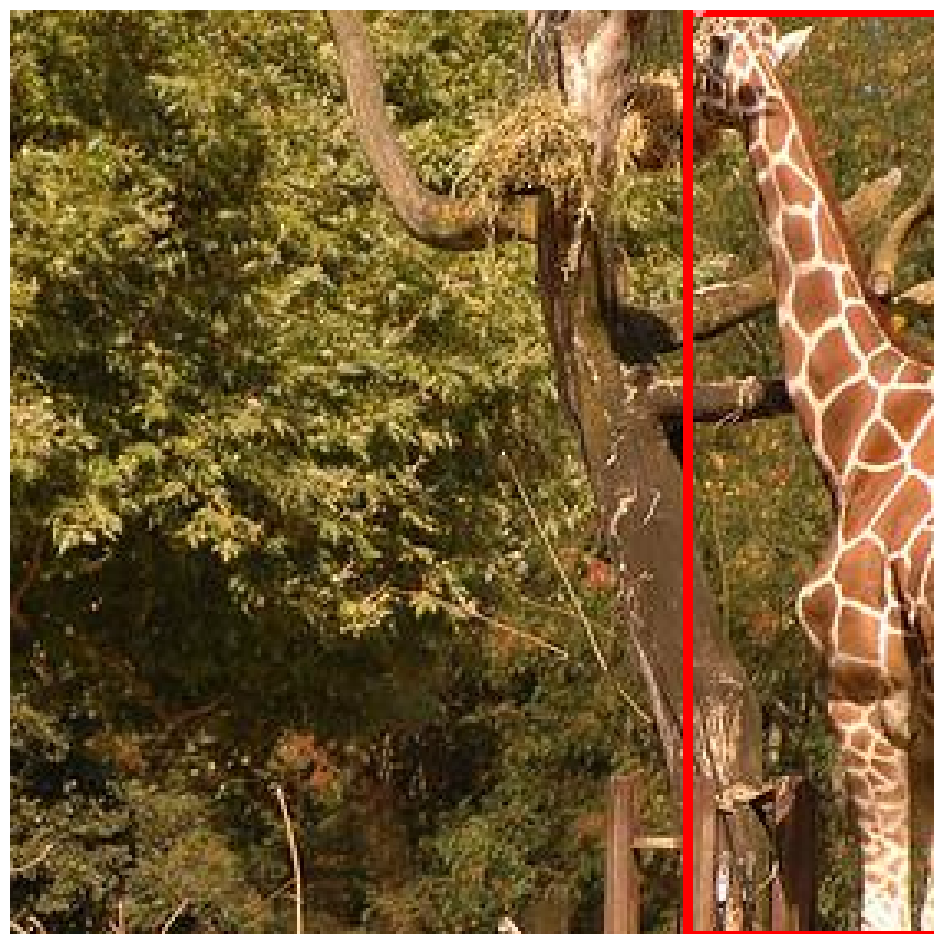

In [69]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed["image"],
    transformed["bboxes"],
    transformed["category_ids"],
    category_id_to_name,
)


As you see the output contains two bounding boxes.

### Define an augmentation pipeline with `min_area`

Next, we will set the `min_area` value to 4500 pixels.

In [70]:
transform = A.Compose(
    [
        A.CenterCrop(height=280, width=280, p=1),
        A.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo", min_area=4500, label_fields=["category_ids"]
    ),
)


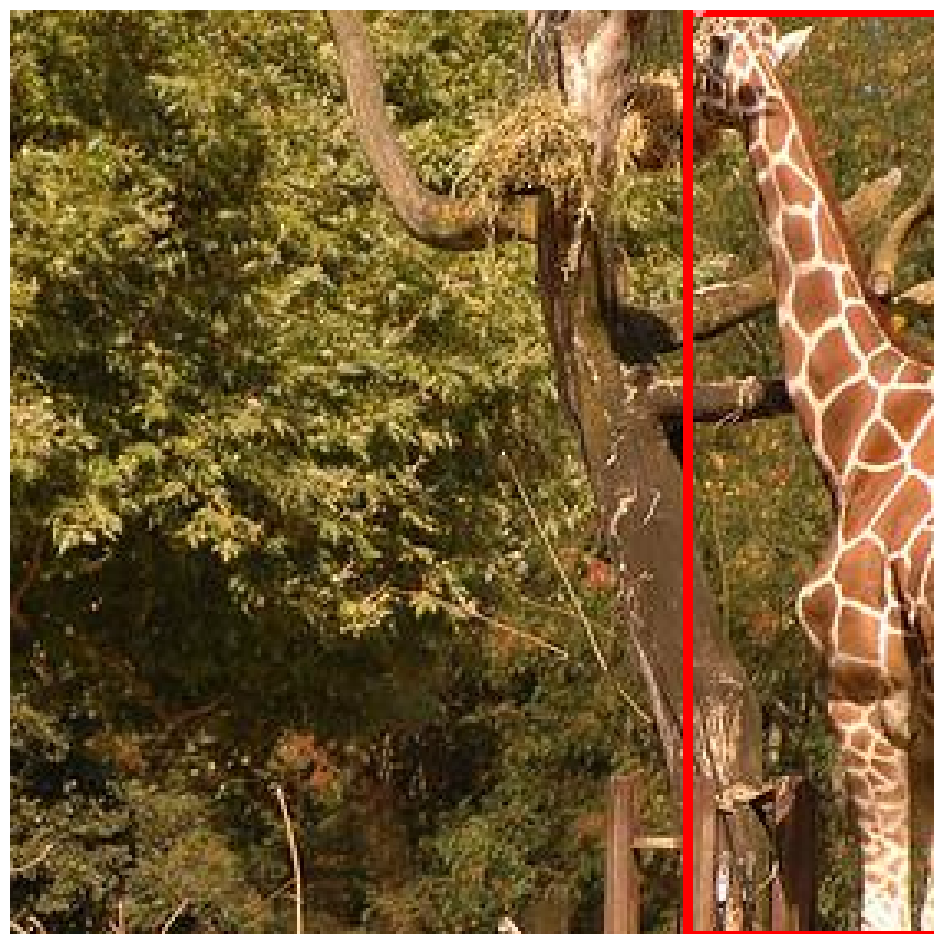

In [71]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed["image"],
    transformed["bboxes"],
    transformed["category_ids"],
    category_id_to_name,
)


The output contains only one bounding box because the area of the second bounding box became lower than 4500 pixels.

### Define an augmentation pipeline with `min_visibility`

Finally, we will set `min_visibility` to 0.3. So if the area of the output bounding box is less than 30% of the original area, Albumentations won't return that bounding box.

In [72]:
transform = A.Compose(
    [
        A.CenterCrop(height=280, width=280, p=1),
        A.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo", min_visibility=0.3, label_fields=["category_ids"]
    ),
)


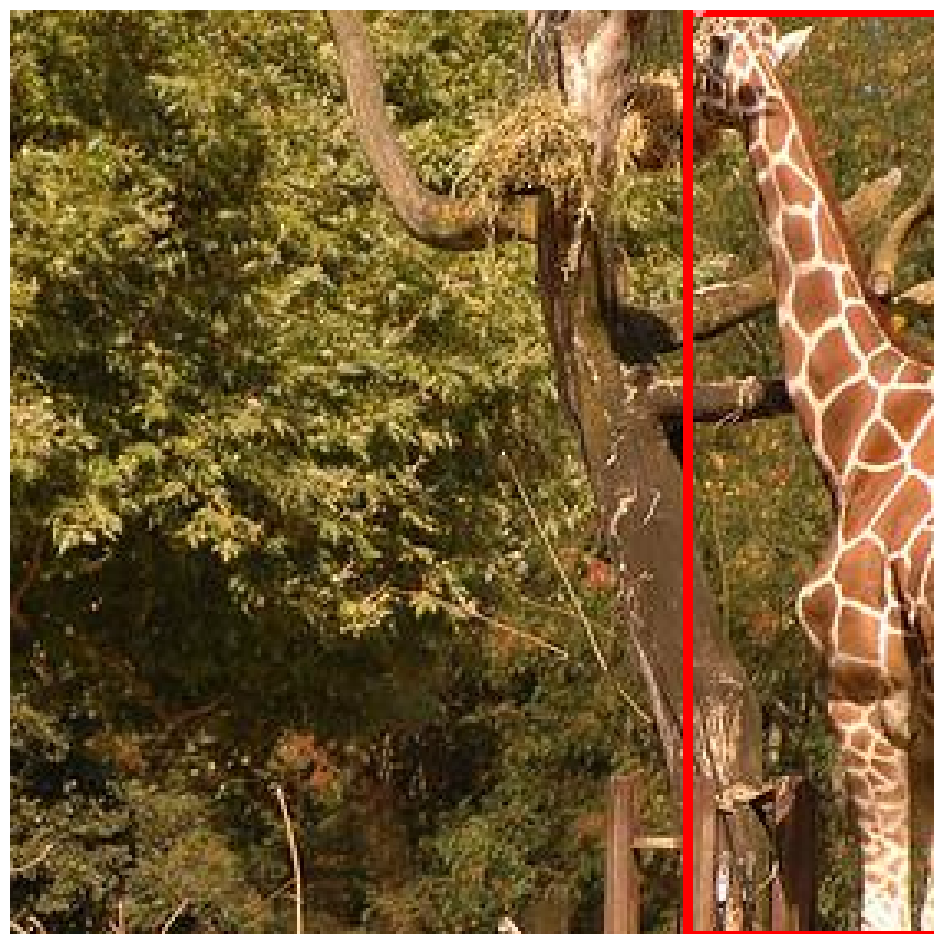

In [73]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed["image"],
    transformed["bboxes"],
    transformed["category_ids"],
    category_id_to_name,
)


The output doesn't contain any bounding box.

Note that you can declare both the `min_area` and `min_visibility` parameters simultaneously in one `BboxParams` instance.

In [7]:
for x in zip([1,3,4,5],[(1,2),(10,20),(100,200)]) :
    print(x)

(1, (1, 2))
(3, (10, 20))
(4, (100, 200))
